In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import swan_vis as swan
from scipy import sparse
import pyranges.pyranges as pr
import pyranges as pyranges

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

## Create SwanGraph

In [2]:
annot = '../../refs/gencode_v29_sirv4_ercc.gtf'
ab = '../talon/human_talon_abundance_filtered.tsv'
gtf = '../talon/human_known_nic_nnc_talon.gtf'

In [3]:
sg = swan.SwanGraph()
sg.add_annotation(annot)
sg.add_transcriptome(gtf)
sg.add_abundance(ab)

In [5]:
sg.save_graph('swan')

Saving graph as swan.p


## Get metadata

In [32]:
sg = swan.read('swan.p')
meta = sg.adata.obs.copy(deep=True)
meta.reset_index(inplace=True, drop=True)
meta['sample'] = meta.dataset.str.rsplit('_', n=2, expand=True)[0]

tissue_df = get_tissue_metadata()
tissue_df = tissue_df[['tissue', 'biosample']]
tissue_df.rename({'biosample': 'sample'}, axis=1, inplace=True)

meta = meta.merge(tissue_df, how='left', on='sample')
meta.head()
meta['classification'] = 'tissue'
meta.loc[meta.tissue.isnull(), 'classification'] = 'cell_line'

meta.loc[meta.tissue.isnull(), 'tissue'] = meta.loc[meta.tissue.isnull(), 'sample']
meta.drop('sample', axis=1, inplace=True)
meta.rename({'tissue': 'sample'}, axis=1, inplace=True)

print('Found {} total samples'.format(len(meta['sample'].unique().tolist())))

Read in graph from swan.p
Found 31 total samples


In [34]:
meta.to_csv('swan_metadata.tsv', sep='\t', index=False)

## Add metadata

In [35]:
sg = swan.read('swan.p')

Read in graph from swan.p


In [36]:
meta = 'swan_metadata.tsv'
sg.add_metadata('swan_metadata.tsv')

# colors
c_dict, order = get_biosample_colors()
sg.set_metadata_colors('sample', c_dict)

sg.save_graph('swan')

Saving graph as swan.p


/Users/fairliereese/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:794: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


## Observed intron chain, TSS, TES 

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import swan_vis as swan
from scipy import sparse
import pyranges.pyranges as pr
import pyranges as pyranges

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

In [2]:
sg = swan.read('swan.p')

Read in graph from swan.p


In [81]:
# get list of detected filtered isoforms
df = pd.read_csv('../talon/human_talon_abundance_filtered.tsv', sep='\t')
df, inds = get_tpm_table(df,
                   how='iso',
                   min_tpm=1,
                   gene_subset='polya')

Calculating iso TPM values
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 156027
# isos >= 1 tpm: 141390
Applying gene type and novelty subset
Number of isos reported: 129369


In [82]:
all_df, regions = get_ic_tss_tes(sg, 
                             novel_tids=inds, 
                             verbose=True)


Finding tsss for 206761 annotated transcripts
Collapsing 190907 annotated tsss
Found 136738 unique tss regions from the annotation
for 190907 unique gene / splice / and tss combinations
Finding tsss for 24066 novel transcripts
Assigning 14621 tsss to preexisiting annotated regions
Found 10621 novel tsss that are already in the annotation
Finding regions for 4000 novel tsss
for 4000 gene, sd, and tss combinations
Found 3887 novel tss clusters
9 new tss regions overlap annotated regions
Clustered 194907 unique gid, first_sd, tss combinations

Finding tess for 206761 annotated transcripts
Collapsing 187202 annotated tess
Found 137966 unique tes regions from the annotation
for 187202 unique gene / splice / and tes combinations
Finding tess for 24066 novel transcripts
Assigning 11639 tess to preexisiting annotated regions
Found 9039 novel tess that are already in the annotation
Finding regions for 2600 novel tess
for 2600 gene, sd, and tes combinations
Found 2554 novel tes clusters
0 new t

In [83]:
# determine the annotation status of each junction chain, tss, tes
cols = ['intron_chain', 'tss', 'tes']
for col in cols:
    known = all_df.loc[all_df.annotation == True, col].unique().tolist()
    new_col = '{}_novel'.format(col)
    all_df[new_col] = True
    all_df.loc[all_df[col].isin(known), new_col] = False

In [105]:
def count_tss_ic_tes(df, subset=None):
    df = df.copy(deep=True)
    
    df = df.loc[df.tid.isin(subset)]
    gene_df = df[['gid', 'gname']]
    gene_df.drop_duplicates(inplace=True)
    
    # raw tss, ic, tes count
    cols = ['tss', 'intron_chain', 'tes']
    for i, col in enumerate(cols):
        if col in ['tss', 'tes']:
            id_col = '{}_cluster'.format(col)
        else:
            id_col = col
        temp = df[[id_col, 'gid']].groupby('gid').nunique()
        if i == 0:
            counts = temp
        else:
            counts = counts.merge(temp, left_index=True, right_index=True)
            
    # unique combinations of tss, ic, tes
    df['tss_ic_tes'] = df.tss_cluster.astype(str)+'_'+\
                       df.intron_chain.astype(str)+'_'+\
                       df.tes_cluster.astype(str)
    temp = df[['tss_ic_tes', 'gid']].groupby('gid').nunique()
    counts = counts.merge(temp, how='left', left_index=True, right_index=True)
    
    for col in counts.columns:
        counts.rename({col: 'n_{}'.format(col)}, axis=1, inplace=True)
        
    # add gene names
    counts = counts.merge(gene_df, how='left', left_index=True, right_on='gid')
    
    return counts

In [106]:
# annotated counts
tids = all_df.loc[all_df.novelty == 'Known'].tid.tolist()
annot_counts = count_tss_ic_tes(all_df, subset=tids)

In [107]:
# annotated + novel counts
tids = list(set(tids)|set(inds))
annot_obs_counts = count_tss_ic_tes(all_df, subset=tids)

In [110]:
annot_counts.head()
annot_counts.loc[annot_counts.gname=='ELN']

,n_tss_cluster,n_intron_chain,n_tes_cluster,n_tss_ic_tes,gid,gname
26437,7,34,13,34,ENSG00000049540.16,ELN


In [111]:
annot_obs_counts.head()
annot_obs_counts.loc[annot_obs_counts.gname=='ELN']

,n_tss_cluster,n_intron_chain,n_tes_cluster,n_tss_ic_tes,gid,gname
7819,7,158,13,158,ENSG00000049540.16,ELN


In [112]:
len(all_df.loc[(all_df.gname == 'ELN')&(all_df.tid.isin(inds)])

158

In [38]:
# for annotated transcripts - compute # tss, ic, tes, and unique combinations
cols = ['tss', 'intron_chain', 'tes']
annot_counts = pd.DataFrame()
for col in cols: 
    temp = all_df.loc[all_df.novelty == 'Known'].copy(deep=True)
    temp.reset_index(drop=True)
    if col == 'tss' or col == 'tes':
        temp = temp[['{}_cluster'.format(col), 'gid']].groupby('gid').nunique()
    else:
        temp = temp[[col, 'gid']].groupby('gid').nunique()
    annot_counts = pd.concat([annot_counts, temp], axis=1)
    
# finally, compute unique combinations of tss, ic, and tes
temp = all_df.loc[all_df.novelty == 'Known'].copy(deep=True)
temp['tss_ic_tes'] = temp.tss_cluster.astype('str')+'_'+temp.intron_chain.astype('str')+'_'+temp.tes_cluster.astype('str')
temp = temp[['tss_ic_tes', 'gid']].groupby('gid').nunique()
annot_counts = annot_counts.merge(temp, how='left', left_on='gid', right_index=True)

In [39]:
# for annotated + novel transcripts - compute # tss, ic, tes, and unique combinations


             tname                gid   gname  \
116344  WASH7P-201  ENSG00000227232.5  WASH7P   

                                                     path                tid  \
116344  [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 2...  ENST00000488147.1   

                                                 loc_path  annotation novelty  \
116344  [221, 219, 217, 216, 215, 214, 213, 212, 211, ...        True   Known   

                                             intron_chain  tss  ...  \
116344  (16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 2...  221  ...   

        tss_cluster  tss_annotation tss_novelty  tes_cluster tes_annotation  \
116344       9037.0            True       Known       8989.0           True   

        tes_novelty  intron_chain_novel tss_novel tes_novel  \
116344        Known               False     False     False   

                                               tss_ic_tes  
116344  9037.0_(16, 17, 18, 19, 20, 21, 22, 23, 24, 25...  

[1 rows x 26 columns]
tss_i

In [40]:
annot_counts.head()

,tss_cluster,intron_chain,tes_cluster,tss_ic_tes
gid,,,,
ENSG00000000003.14,4,5,5,5
ENSG00000000005.5,2,2,2,2
ENSG00000000419.12,2,6,2,6
ENSG00000000457.13,3,5,4,5
ENSG00000000460.16,6,9,5,9


In [34]:
annot_counts.loc[~annot_counts.tss_ic_tes.isnull()]

,tss_cluster,intron_chain,tes_cluster,tss_ic_tes
gid,,,,
ENSG00000000003.14,4,5,5,5
ENSG00000000005.5,2,2,2,2
ENSG00000000419.12,2,6,2,6
ENSG00000000457.13,3,5,4,5
ENSG00000000460.16,6,9,5,9
...,...,...,...,...
ENSG00000285990.1,1,1,1,1
ENSG00000285991.1,1,1,1,1
ENSG00000285992.1,1,1,1,1


In [41]:
# add gene name
genes = sg.t_df[['gid', 'gname']].drop_duplicates().reset_index(drop=True)
annot_counts = annot_counts.merge(genes, how='left', left_index=True, right_on='gid')
annot_counts.rename({'tss_cluster': 'tss', 'tes_cluster': 'tes'},
          axis=1, inplace=True)

In [44]:
annot_counts.loc[annot_counts.tss_ic_tes.isnull()]

,tss,intron_chain,tes,tss_ic_tes,gid,gname


In [42]:
annot_counts.loc[annot_counts.gname == 'ELN']

,tss,intron_chain,tes,tss_ic_tes,gid,gname
2645,7,34,13,34,ENSG00000049540.16,ELN


In [22]:
len(all_df.loc[(all_df.novelty == 'Known')&(all_df.gname == 'ELN')])

34

In [274]:
# # assign ends from novel transcripts to annotated ends
# df = all_df.loc[(all_df.annotation == False)&(all_df.tid.isin(sg.adata.var.index.tolist()))]

# n = len(df.index)
# print('Finding {}s for {} novel transcripts'.format(c, n))

# # join in pandas cause pyranges is silly as hecc
# cols = ['gid', 'gname', '{}_coord'.format(c), '{}_chrom'.format(c), c]
# if c == 'tss':
#     cols.append('first_sd')
# ends = df[cols].copy(deep=True)
# ends.rename({'{}_coord'.format(c): 'Start',
#              '{}_chrom'.format(c): 'Chromosome'},
#              axis=1, inplace=True)
# ends['End'] = ends.Start
# ends.drop_duplicates(inplace=True)
# n = len(ends.index)
# print('Assigning {} {}s to preexisiting annotated regions'.format(n, c))

# # to hold the cluster results
# o_clust = pd.DataFrame()

# # case 1: ends from novel transcripts are within annotated regions
# cols = ['gid']
# if c == 'tss':
#     cols.append('first_sd')
# ends = ends.merge(a_reg, how='left', on=cols, suffixes=('', '_annot'))
# ends['in_region'] = False
# ends.loc[(ends.annotation==True)&(ends.Start>=ends.Start_annot)&(ends.Start<=ends.End_annot), 'in_region'] = True
# cols = ['gid', 'gname', 'Start', 'Chromosome', c, 'End']
# if c == 'tss':
#     cols.append('first_sd')
# ends.sort_values(by='in_region', inplace=True, ascending=False)
# ends.drop_duplicates(subset=cols, keep='first', inplace=True)
# o_clust = pd.concat([o_clust, ends.loc[ends.in_region == True]])
# n = len(ends.loc[ends.in_region == True].index)
# print('Found {} novel {}s that are already in the annotation'.format(n,c))

# # case 2: ends from novel transcripts need to be clustered
# # on their own
# ends = ends.loc[ends.in_region == False]
# print(ends.head())
# n = len(ends.index)
# print('Finding regions for {} novel {}s'.format(n,c))
# cols = ['gid', c]
# if c == 'tss':
#     cols.append('first_sd')
# n = len(ends[cols].drop_duplicates().index)
# print('for {} gene, sd, and {} combinations'.format(n, c))
# cols = ['Chromosome_annot', 'Start_annot', 'End_annot',
#         'len', 'Cluster', 'annotation', 'in_region', 'gname_annot']
# ends.drop(cols, inplace=True, axis=1)

# # merge to get regions, start cluster numbering from max of 
# # annotated clusters
# n_reg = pr.PyRanges(df=ends)
# cols = ['gid', 'gname']
# if c == 'tss':
#     cols.append('first_sd')
# n_reg = n_reg.merge(strand=None, by=cols, slack=200)
# n_reg = n_reg.as_df()
# n_reg['len'] = n_reg['End'] - n_reg['Start']
# n_annot = a_clust.Cluster.max()
# n_reg['Cluster'] = [i for i in range(n_annot+1, len(n_reg.index)+n_annot+1)]
# n_reg['annotation'] = True
# n = len(n_reg.index)
# print('Found {} novel {} clusters'.format(n,c))

# # cluster
# n_clust = pr.PyRanges(df=ends)
# cols = ['gid', 'gname']
# if c == 'tss':
#     cols.append('first_sd')
# n_clust = n_clust.cluster(strand=None, by=cols, slack=100)
# n_clust = n_clust.as_df()
# n_clust['Cluster_new'] = n_clust.Cluster+n_annot
# n_clust.drop('Cluster', axis=1, inplace=True)
# n_clust.rename({'Cluster_new': 'Cluster'}, axis=1, inplace=True)
# n_clust['{}_novelty'.format(c)] = 'Novel'

# # how many of the novel clusters fall into the regions that 
# # were already annotated?
# n_reg = pr.PyRanges(df=n_reg)
# a_reg= pr.PyRanges(df=a_reg)
# temp = n_reg.join(a_reg, how=None, strandedness=None, suffix='_annot')
# temp = temp.as_df()
# a_reg = a_reg.as_df()
# if c == 'tss':
#     n = len(temp.loc[(temp.first_sd == temp.first_sd_annot)&(temp.gid == temp.gid_annot)].index)
# elif c == 'tes':
#     n = len(temp.loc[temp.gid == temp.gid_annot].index)
# print('{} new {} regions overlap annotated regions'.format(n,c))







In [264]:
clust = pd.concat([a_clust, n_clust])
clust = clust[['gid', 'gname', 'first_sd', c, 'Cluster', 'annotation', 'tss_novelty']]
clust.rename({'Cluster': '{}_cluster'.format(c), 'annotation': '{}_annotation'.format(c)}, axis=1, inplace=True)
n = len(clust[['gid', 'first_sd', 'tss']].drop_duplicates().index)
print('Clustered {} unique gid, first_sd, tss combinations'.format(n))
clust.head()

Clustered 195142 unique gid, first_sd, tss combinations


,gid,gname,first_sd,tss,tss_cluster,tss_annotation,tss_novelty
0,ENSG00000000457.13,SCYL3,67217,67218,1,True,Known
1,ENSG00000000457.13,SCYL3,67220,67221,2,True,Known
2,ENSG00000000457.13,SCYL3,67220,67222,2,True,Known
3,ENSG00000000457.13,SCYL3,67223,67224,3,True,Known
4,ENSG00000000460.16,C1orf112,67033,67032,4,True,Known


In [232]:
clust.source.unique()

array(['gencode', 'novel_denovo'], dtype=object)

In [233]:
n = len(all_df[['gid', 'first_sd', 'tss']].drop_duplicates().index)
print('{} unique gid, first_sd, tss combinations in df'.format(n))

195528 unique gid, first_sd, tss combinations in df


In [234]:
clust.loc[clust.tss_cluster.isnull()]

,gid,gname,first_sd,tss,tss_cluster,tss_annotation,source


In [235]:
print(len(all_df.index))
all_df = all_df.merge(clust, how='left', on=['gid', 'gname', c, 'first_sd'])
print(len(all_df.index))

231154
231154


In [236]:
# all gene, first_sd, and tss combos without a cluster were 
# from novel genes
temp = all_df.loc[all_df.tss_cluster.isnull()]
temp['novel_gene'] = temp.gid.str.contains('ENCODEH')
temp = temp[['tss', 'novel_gene']].groupby('novel_gene').count()
temp

,tss
novel_gene,
False,618


In [238]:
# where are duplicated things coming from ?
temp = all_df.loc[all_df[['tid', 'gid', 'tss', 'first_sd']].duplicated(keep='first')]
print(len(temp.index))
temp = all_df.loc[all_df[['tid', 'gid', 'tss', 'first_sd']].duplicated(keep=False)]
temp.tail()
temp = all_df.loc[all_df[['tid', 'gid', 'tss', 'first_sd', 'source']].duplicated(keep=False)]
print(len(temp.index))
# now there are no more!

0
0


In [19]:
# only get annotation first
df = all_df.loc[all_df.annotation == True].copy(deep=True)

# susbet on relevant genes 
if subset:
    gene_df, _, _ = get_gtf_info(how='gene', subset=subset)
    genes = gene_df.gid.tolist()
    df = df.loc[df.gid.isin(genes)]
    
# to call regions, first cluster w/i distance in annotated transcipts
cols = ['tss', 'tes']
regions = dict()
for c in cols:
    
    # turn into pyranges obj
    ends = df[['gid', 'gname', 'first_sd', 
               '{}_coord'.format(c),
               '{}_chrom'.format(c), c]].copy(deep=True)
    ends.rename({'{}_coord'.format(c): 'Start',
                 '{}_chrom'.format(c): 'Chromosome'}, axis=1, inplace=True)
    ends['End'] = ends.Start
    end_rgs = pr.PyRanges(df=ends)

    # cluster the starts / ends 
    ends = end_rgs.cluster(strand=None, by=['gid', 'gname', 'first_sd'], slack=200)
    ends = ends.as_df()

    # also use merge to store extra info
    end_regions = end_rgs.merge(strand=None, by=['gid', 'gname', 'first_sd'], slack=200)
    end_regions = end_regions.as_df()
    end_regions['len'] = end_regions['End'] - end_regions['Start']
    end_regions['annotation'] = True
    regions[c] = end_regions

    # add to df
    ends = ends[['gid', 'gname', c, 'first_sd', 'Cluster']]
    ends.rename({'Cluster': '{}_cluster'.format(c)}, axis=1, inplace=True)
    ends.drop_duplicates(inplace=True)
    df = df.merge(ends, how='left', on=['gid', 'gname', 'first_sd', c], suffixes=('', '_annot'))

NameError: name 'all_df' is not defined

In [81]:
kind = 'obs'

In [144]:
# determine which region each observed novel transcript belongs to
nov_regions_dict = dict()
if kind == 'obs': 
    nov_df = all_df.loc[(all_df.annotation == False)&(all_df.tid.isin(sg.adata.var.index.tolist()))]
    
    # # remove sirv / ercc
    # nov_df = nov_df.loc[~(nov_df.chr.str.contains('SIRV'))&~(nov_df.chr.str.contains('ERCC'))]
    
    # remove novel genes
    nov_df = nov_df.loc[~nov_df.gid.str.contains('ENCODEHG')]
    
    cols = ['tss', 'tes']
    for c in cols:
        
        # turn into pyranges object
        ends = nov_df[['gid', 'gname', 'first_sd',
                       '{}_coord'.format(c),
                       '{}_chrom'.format(c), c]].copy(deep=True)
        ends.rename({'{}_coord'.format(c): 'Start',
                     '{}_chrom'.format(c): 'Chromosome'}, axis=1, inplace=True)
        ends['End'] = ends.Start
        ends.drop_duplicates(inplace=True)

        # intersect these ends with preexisting ends, first just on gene id and first_sd
        n = len(ends.index)
        print('Intersecting {} unique {}s with the annotated end regions'.format(n, c))
        ends = ends.merge(annot, how='left', on=['gid', 'first_sd'], suffixes=('', '_annot'))
        
        # then based on genomic coordinates
        ends['in_annot_region'] = False
        ends.loc[(ends.annotation == True)&(ends.Start >= ends.Start_annot)&(ends.Start <= ends.End_annot), 'in_annot_region'] = True
        
        # remove entries that were assigned to an annotated region (ie merged
        # on first_sd and gid) but didn't fall within that region
        cols = ['gid', 'gname', 'first_sd', 'Start', 'Chromosome', 'tss', 'End']
        ends.sort_values(by='in_annot_region', inplace=True, ascending=False)
        ends.drop_duplicates(subset=cols, keep='first', inplace=True)
        
        # for entries that don't fall with in the annotated region they were matched with, replace with nans to 
        # signify that we need a new region made
        cols = ['Chromosome_annot', 'Start_annot', 'End_annot', 'gname_annot', 'len', 'annotation']
        ends.loc[ends.in_annot_region == False, cols] = np.nan
        
        print(ends.head())
        
        # number of observed regions that did not fall in annotated regions
        n = len(ends.loc[ends.in_annot_region == False].index)
        print('Found {} unique {}s with ends that are outside of annotated regions'.format(n, c))
        
        # for the ends that fall outside the annotated regions, cluster them
        nov_obs = ends.loc[ends.in_annot_region == False]
        nov_obs = pr.PyRanges(df=nov_obs)
        nov_obs = nov_obs.cluster(strand=None, by=['gid', 'gname', 'first_sd'], slack=100)
        nov_obs = nov_obs.as_df()

        # also use merge to store extra info
        nov_regions = ends.loc[ends.in_annot_region == False]
        nov_regions = pr.PyRanges(df=nov_regions)
        nov_regions = nov_regions.merge(strand=None, by=['gid', 'gname', 'first_sd'], slack=100)
        nov_regions = nov_regions.as_df()
        nov_regions['len'] = nov_regions['End'] - nov_regions['Start']
        nov_regions['annotation'] = True
        nov_regions_dict[c] = nov_regions
        
        # how many of the collapsed observed peaks overlap with known peaks?
        nov_regions = pr.PyRanges(df=nov_regions)
        annot = pr.PyRanges(df=annot)
        nov_regions = nov_regions.join(annot, how=None, strandedness=None, suffix='_annot')
        nov_regions = nov_regions.as_df()
        annot = annot.as_df()

        # there are only like 10 regions that overlap in terms of gid, first_sd, and region
        n = len(nov_regions.loc[(nov_regions.first_sd == nov_regions.first_sd_annot)&(nov_regions.gid == nov_regions.gid_annot)].index)
        print('Found {} novel {} regions that overlap annotated regions'.format(n, c))
        
        
        
        break
                       
    

Intersecting 14670 unique tsss with the annotated end regions
                      gid     gname  first_sd     Start Chromosome     tss  \
14455  ENSG00000101199.12   ARFGAP1    587225  63284308      chr20  587223   
8032   ENSG00000168763.15     CNNM3    524146  96816250       chr2  524145   
8034   ENSG00000125319.14  C17orf53    397477  44141906      chr17  397474   
8035   ENSG00000125319.14  C17orf53    397477  44141908      chr17  397475   
8036    ENSG00000149823.8     VPS51    153632  65096159      chr11  153626   

            End Chromosome_annot  Start_annot   End_annot gname_annot    len  \
14455  63284308            chr20   63284292.0  63284308.0     ARFGAP1   16.0   
8032   96816250             chr2   96816245.0  96816250.0       CNNM3    5.0   
8034   44141906            chr17   44141906.0  44142022.0    C17orf53  116.0   
8035   44141908            chr17   44141906.0  44142022.0    C17orf53  116.0   
8036   65096159            chr11   65096115.0  65096244.0       VPS51

In [143]:
ends.head()

,gid,gname,first_sd,Start,Chromosome,tss,End,Chromosome_annot,Start_annot,End_annot,gname_annot,len,annotation,in_annot_region
14455,ENSG00000101199.12,ARFGAP1,587225,63284308,chr20,587223,63284308,chr20,63284292.0,63284308.0,ARFGAP1,16.0,True,True
8032,ENSG00000168763.15,CNNM3,524146,96816250,chr2,524145,96816250,chr2,96816245.0,96816250.0,CNNM3,5.0,True,True
8034,ENSG00000125319.14,C17orf53,397477,44141906,chr17,397474,44141906,chr17,44141906.0,44142022.0,C17orf53,116.0,True,True
8035,ENSG00000125319.14,C17orf53,397477,44141908,chr17,397475,44141908,chr17,44141906.0,44142022.0,C17orf53,116.0,True,True
8036,ENSG00000149823.8,VPS51,153632,65096159,chr11,153626,65096159,chr11,65096115.0,65096244.0,VPS51,129.0,True,True


In [142]:
nov_obs.head()

,gid,gname,first_sd,Start,Chromosome,tss,End,Chromosome_annot,Start_annot,End_annot,gname_annot,len,annotation,in_annot_region,Cluster
0,ENSG00000000460.16,C1orf112,67124,169794730,chr1,67114,169794730,NaN,NaN,NaN,NaN,NaN,NaN,False,1
1,ENSG00000000460.16,C1orf112,67125,169795043,chr1,67120,169795043,NaN,NaN,NaN,NaN,NaN,NaN,False,2
2,ENSG00000007933.12,FMO3,67464,171090917,chr1,67462,171090917,NaN,NaN,NaN,NaN,NaN,NaN,False,3
3,ENSG00000007933.12,FMO3,67485,171107675,chr1,67481,171107675,NaN,NaN,NaN,NaN,NaN,NaN,False,4
4,ENSG00000008130.15,NADK,2707,1779157,chr1,2708,1779157,NaN,NaN,NaN,NaN,NaN,NaN,False,5


In [99]:
ends = ends.merge(annot, how='left', on=['gid', 'first_sd'], suffixes=('', '_annot'))

In [100]:
# # make sure this tss coord falls within the region merged with 
# wat = end_rgs.copy(deep=True)
# wat['in_annot_region'] = False
# wat = wat.loc[wat.gname == 'LINC01128']
# wat.loc[(wat.annotation == True)&(wat.Start >= wat.Start_annot)&(wat.Start <= wat.End_annot), 'in_annot_region'] = True

In [101]:
# wat.Start.astype(int) >= wat.Start_annot.astype(int)
# print(wat.Start.astype(int))
# print(wat.Start_annot.astype(int))

# print(wat.Start.astype(int).values)
# print(wat.Start_annot.astype(int).values)
# print(wat.Start.values == wat.Start_annot.values)

In [102]:
# make sure this tss coord falls within the region merged with 
ends['in_annot_region'] = False
ends.loc[(ends.annotation == True)&(ends.Start >=ends.Start_annot)&(ends.Start <= ends.End_annot), 'in_annot_region'] = True

In [103]:
# remove entries that were assigned to an annotated region (ie merged
# on first_sd and gid) but didn't fall within that region
cols = ['gid', 'gname', 'first_sd', 'Start', 'Chromosome', 'tss', 'End']
ends.sort_values(by='in_annot_region', inplace=True, ascending=False)
ends.drop_duplicates(subset=cols, keep='first', inplace=True)
len(ends.index)

14670

In [104]:
# for entries that don't fall with in the annotated region they were matched with, replace with nans to 
# signify that we need a new region made
cols = ['Chromosome_annot', 'Start_annot', 'End_annot', 'gname_annot', 'len', 'annotation']
ends.loc[ends.in_annot_region == False, cols] = np.nan

In [110]:
# number of observed regions that did not fall in annotated regions
len(ends.loc[ends.in_annot_region == False].index)

4049

In [111]:
# # no output, so start always < end
# end_rgs.loc[(end_rgs.annotation == True)&(end_rgs.Start < end_rgs.Start_annot)&(end_rgs.Start > end_rgs.End_annot)]

In [112]:
# collapse observed regions that did not fall into annotated regions 
# w/ binwidth 100
temp = ends.loc[ends.in_annot_region == False]
temp = pr.PyRanges(df=temp)
temp = temp.merge(strand=None, by=['gid', 'gname', 'first_sd'], slack=100)
temp = temp.as_df()

temp['len'] = temp.End - temp.Start

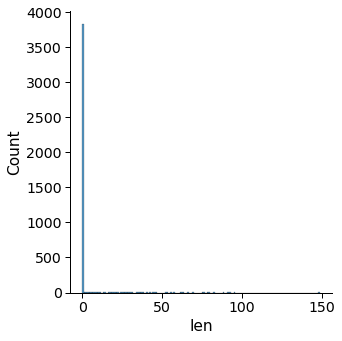

In [113]:
sns.displot(temp, x='len', binwidth=1)

In [116]:
# how many of the collapsed observed peaks overlap with known peaks?
temp = pr.PyRanges(df=temp)
annot = pr.PyRanges(df=annot)
temp = temp.join(annot, how=None, strandedness=None, suffix='_annot')

temp = temp.as_df()
annot = annot.as_df()

# there are only like 10 regions that overlap in terms of gid, first_sd, and region
temp.loc[(temp.first_sd == temp.first_sd_annot)&(temp.gid == temp.gid_annot)]

In [128]:
temp.head()

,Chromosome,Start,End,gid,gname,first_sd,len,Start_annot,End_annot,gid_annot,gname_annot,first_sd_annot,len_annot,annotation
0,chr1,171090917,171090917,ENSG00000007933.12,FMO3,67464,0,171090877,171090919,ENSG00000007933.12,FMO3,67465,42,True
1,chr1,117929724,117929724,ENSG00000065183.15,WDR3,48551,0,117929720,117929768,ENSG00000065183.15,WDR3,48550,48,True
2,chr1,8878692,8878692,ENSG00000074800.15,ENO1,6099,0,8878646,8878720,ENSG00000074800.15,ENO1,6098,74,True
3,chr1,51878805,51878805,ENSG00000078618.21,NRDC,29876,0,51878723,51878937,ENSG00000078618.21,NRDC,29875,214,True
4,chr1,46604246,46604246,ENSG00000079277.20,MKNK1,28365,0,46604214,46604294,ENSG00000079277.20,MKNK1,28362,80,True


,Chromosome,Start,End,gid,gname,first_sd,len,Start_annot,End_annot,gid_annot,gname_annot,first_sd_annot,len_annot,annotation
5,chr1,46247700,46247769,ENSG00000085999.11,RAD54L,27984,69,46247732,46247732,ENSG00000085999.11,RAD54L,27984,0,True
76,chr3,48609626,48609636,ENSG00000010256.10,UQCRC1,636369,10,48609631,48609631,ENSG00000010256.10,UQCRC1,636369,0,True
181,chr7,45111697,45111718,ENSG00000136270.13,TBRG4,816473,21,45111708,45111708,ENSG00000136270.13,TBRG4,816473,0,True
305,chr12,57230328,57230368,ENSG00000182199.10,SHMT2,208843,40,57230354,57230354,ENSG00000182199.10,SHMT2,208843,0,True
353,chr15,22838641,22838676,ENSG00000140157.14,NIPA2,286013,35,22838644,22838658,ENSG00000140157.14,NIPA2,286013,14,True
377,chr16,668086,668124,ENSG00000140983.13,RHOT2,322689,38,668105,668105,ENSG00000140983.13,RHOT2,322689,0,True
405,chr17,74776337,74776367,ENSG00000109065.11,NAT9,413837,30,74776361,74776361,ENSG00000109065.11,NAT9,413837,0,True
414,chr17,78128730,78128782,ENSG00000141524.15,TMC6,417950,52,78128758,78128772,ENSG00000141524.15,TMC6,417950,14,True
462,chr19,19033585,19033664,ENSG00000105676.13,ARMC6,463170,79,19033610,19033635,ENSG00000105676.13,ARMC6,463170,25,True


In [127]:
cols = ['Start_annot', 'End_annot', 'gid_annot', 'gname_annot', 'first_sd_annot', 'len_annot', 'annotation']
temp.loc[(temp.first_sd != temp.first_sd_annot)&(temp.gid != temp.gid_annot), cols] = np.nan()

,Chromosome,Start,End,gid,gname,first_sd,len,Start_annot,End_annot,gid_annot,gname_annot,first_sd_annot,len_annot,annotation
7,chr1,231241170,231241170,ENSG00000116906.12,GNPAT,85574,0,231241090,231241187,ENSG00000143633.12,C1orf131,85565,97,True
13,chr1,99970057,99970057,ENSG00000117620.14,SLC35A3,42079,0,99970011,99970081,ENSG00000283761.1,AC118553.2,42075,70,True
22,chr1,161132668,161132668,ENSG00000143222.11,UFC1,64059,0,161132572,161132688,ENSG00000158796.16,DEDD,64053,116,True
29,chr1,161118086,161118086,ENSG00000158793.13,NIT1,63978,0,161118055,161118111,ENSG00000143256.4,PFDN2,63965,56,True
44,chr1,201829149,201829149,ENSG00000198700.9,IPO9,74952,0,201829085,201829218,ENSG00000231871.5,IPO9-AS1,74947,133,True
70,chr2,197500047,197500047,ENSG00000144381.16,HSPD1,550306,0,197499994,197500140,ENSG00000115541.10,HSPE1,550317,146,True
74,chr2,69643792,69643792,ENSG00000196975.15,ANXA4,515552,0,69643654,69643845,ENSG00000115977.18,AAK1,515543,191,True
75,chr3,50350704,50350704,ENSG00000004838.13,ZMYND10,639497,0,50350695,50350845,ENSG00000114395.10,CYB561D2,639517,150,True
89,chr3,119677403,119677403,ENSG00000121577.13,POPDC2,653380,0,119677294,119677454,ENSG00000138495.6,COX17,653381,160,True
90,chr3,119677364,119677364,ENSG00000121577.13,POPDC2,653382,0,119677294,119677454,ENSG00000138495.6,COX17,653381,160,True


In [123]:
len(temp)

547

90% set 

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import swan_vis as swan
from scipy import sparse
import pyranges.pyranges as pr
import pyranges as pyranges

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

In [2]:
df = pd.read_csv('n_isos_sample_gene_90.tsv', sep='\t')
gids = df.loc[df.n_isos > 1, 'gid'].unique().tolist()
sg = swan.read('swan.p')
df, counts, regions = get_ic_tss_tes(sg,
                                     kind='obs', 
                                     subset=gids)

Read in graph from swan.p
will need to eventually compute / merge these after annotated ones
109741
hewwo
88773


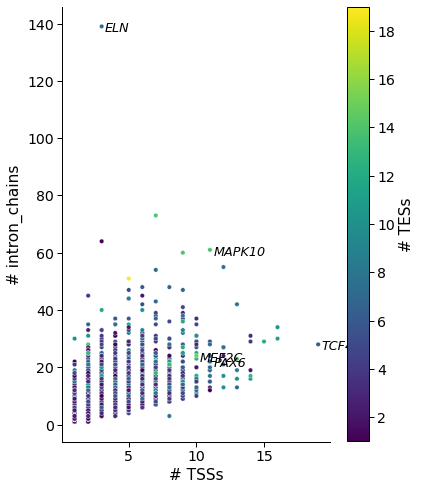

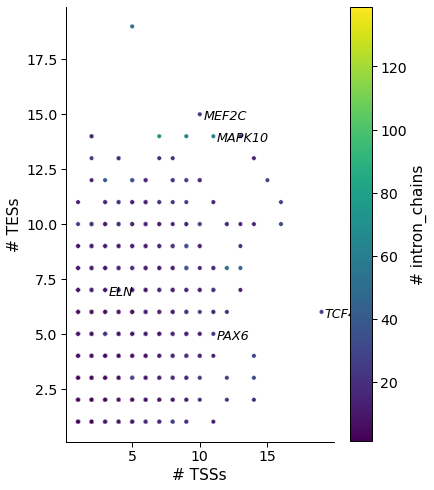

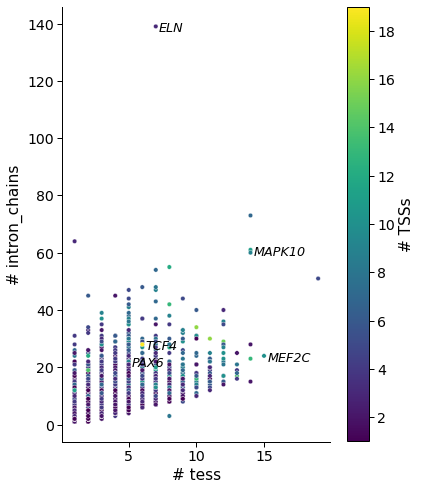

In [3]:
genes = ['PAX6', 'TCF4', 'MAPK10', 'ELN', 'MEF2C', 'MYOD1', 'MYOG']
plot_n_ic_tss_tes(counts, 
                  label_genes=genes,
                  kind='obs',
                  opref='figures/human_90')

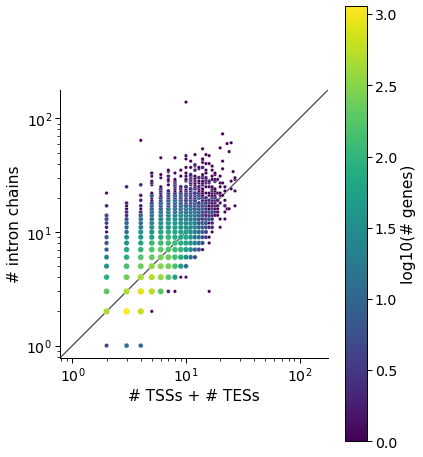

In [4]:
plot_genes_n_ic_ends(counts, 
                     kind='obs', 
                     opref='figures/human_90')

Observed transcripts

In [2]:
sg = swan.read('swan.p')
df, counts, regions = get_ic_tss_tes(sg,
                                     kind='obs', 
                                     subset='polya')

Read in graph from swan.p
will need to eventually compute / merge these after annotated ones


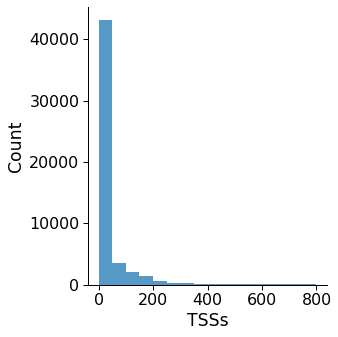

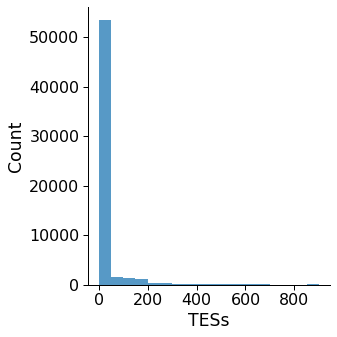

In [3]:
plot_region_widths(regions, 
                   kind='obs',
                   opref='figures/human')

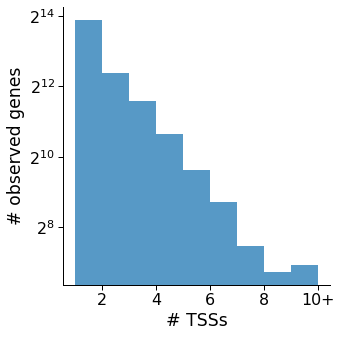

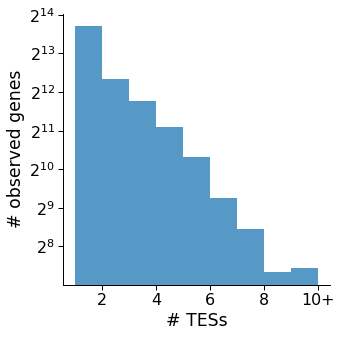

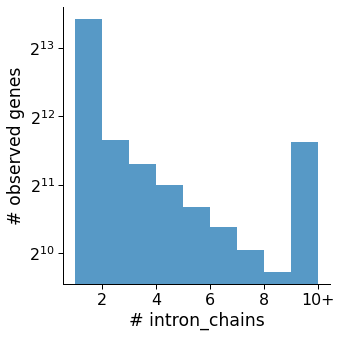

In [38]:
opref = 'figures/human'
kind = 'obs'

temp_counts = counts.melt(id_vars=['gid', 'gname'])
cols = ['tss', 'tes', 'intron_chain']

max_val = 10

for c in cols:
    sns.set_context('paper', font_scale=1.8)
    temp = temp_counts.loc[temp_counts.variable == c].copy(deep=True)
    temp.loc[temp['value'] > 10, 'value'] = 10
    ax = sns.displot(data=temp, x='value', kind='hist',
                     binwidth=1,linewidth=0, log_scale=(0,2))
    
    if c == 'tss' or c == 'tes':
        xlabel = '# {}s'.format(c.upper())
    else:
        xlabel = '# {}s'.format(c)
    
    if kind == 'annot':
        ylabel = '# GENCODE genes'
    elif kind == 'obs':
        ylabel = '# observed genes'
        
    a = [2,4,6,8,10]
    b = a.copy()
    b[-1] = '10+'
    plt.xticks(a, b)
    
    ax.set(xlabel=xlabel, ylabel=ylabel)
    
    fname = '{}_{}_{}_hist.png'.format(opref,kind,c)
    plt.savefig(fname, dpi=300, bbox_inches='tight')


In [46]:
len(counts.index)

26812

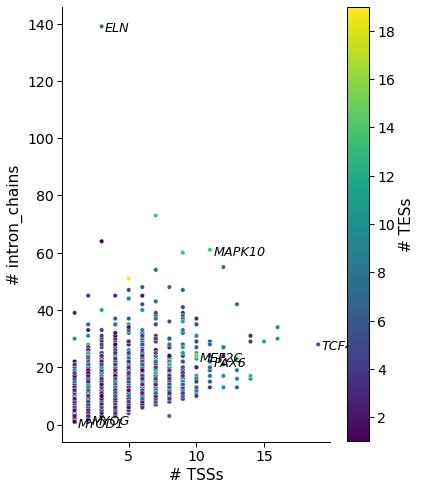

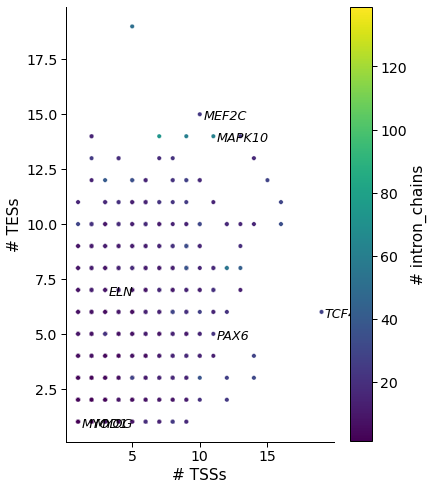

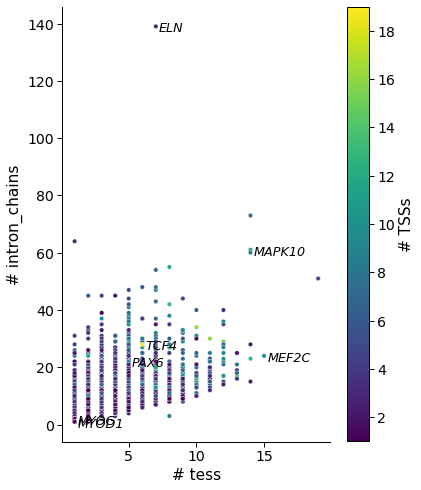

In [3]:
genes = ['PAX6', 'TCF4', 'MAPK10', 'ELN', 'MEF2C', 'MYOD1', 'MYOG']
plot_n_ic_tss_tes(counts, 
                  label_genes=genes,
                  kind='obs',
                  opref='figures/human')

In [6]:
counts.loc[counts.gname.isin(['MYOD1', 'MYOG'])]

,tss,intron_chain,tes,tss_ic_tes,gid,gname
7637,2,2,1,2,ENSG00000122180.4,MYOG
9263,1,1,1,1,ENSG00000129152.3,MYOD1


In [10]:
df.loc[df.gname == 'MYOG']

,tname,gid,gname,path,tid,loc_path,annotation,novelty,intron_chain,tss,...,tss_chrom,tss_coord,tss_cluster,tes_chrom,tes_coord,tes_cluster,intron_chain_novel,tss_novel,tes_novel,tss_ic_tes
6537,MYOG-201,ENSG00000122180.4,MYOG,"[75779, 75780, 75781, 75782, 75783]",ENST00000241651.4,"[75985, 75983, 75982, 75981, 75980, 75979]",True,Known,"(75780, 75781, 75782)",75985,...,chr1,203086036,1164,chr1,203083132,1365,False,False,False,"1164_(75780, 75781, 75782)_1365"
104671,ENCODEHT002380206,ENSG00000122180.4,MYOG,"[955304, 955305, 955306, 75780, 75781, 75782, ...",ENCODEHT002380206,"[75987, 75986, 75984, 75983, 75982, 75981, 759...",False,NNC,"(955305, 955306, 75780, 75781, 75782)",75987,...,chr1,203087433,1165,chr1,203083132,1365,True,True,False,"1165_(955305, 955306, 75780, 75781, 75782)_1365"


In [9]:
sg.t_df.loc[sg.t_df.gname == 'MYOG']

,tname,gid,gname,path,tid,loc_path,annotation,novelty
tid,,,,,,,,
ENCODEHT002380206,ENCODEHT002380206,ENSG00000122180.4,MYOG,"[955304, 955305, 955306, 75780, 75781, 75782, ...",ENCODEHT002380206,"[75987, 75986, 75984, 75983, 75982, 75981, 759...",False,NNC
ENST00000241651.4,MYOG-201,ENSG00000122180.4,MYOG,"[75779, 75780, 75781, 75782, 75783]",ENST00000241651.4,"[75985, 75983, 75982, 75981, 75980, 75979]",True,Known


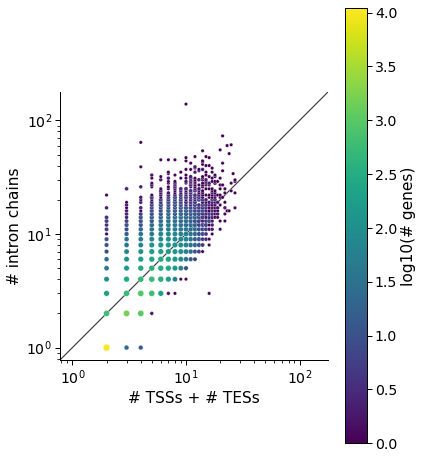

In [9]:
plot_genes_n_ic_ends(counts, 
                     kind='obs', 
                     opref='figures/human')

## Pi / major isoform stuff

Read in graph from swan.p


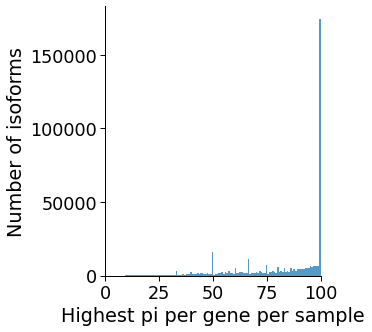

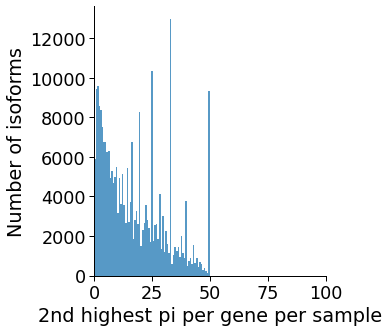

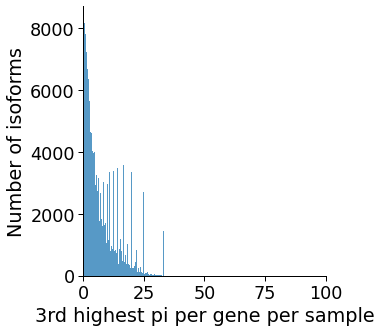

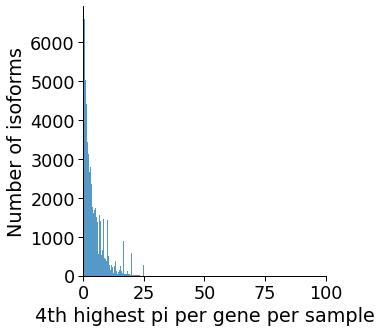

In [2]:
sg = swan.read('swan.p')
plot_major_iso_pis(sg, 'sample', opref='figures/human')

### How many isoforms does it take to get 90% expression / gene / sample?

In [340]:
sg = swan.read('swan.p')
sg.adata.obs['biosample'] = sg.adata.obs['dataset'].str.rsplit('_', n=2, expand=True)[0]

Read in graph from swan.p


In [341]:
len(sg.adata.obs.biosample.unique())

44

In [342]:
sg.adata.obs.groupby('classification').nunique()

,dataset,total_counts,biosample,sample
classification,,,,
cell_line,48,48,21,21
tissue,42,42,23,10


In [ ]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import swan_vis as swan
from scipy import sparse
import pyranges.pyranges as pr
import pyranges as pyranges

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

In [12]:
sg = swan.read('swan.p')
t_df = pd.read_csv('../talon/human_talon_abundance_filtered.tsv', sep='\t')

Read in graph from swan.p


In [13]:
t_df = t_df[['annot_gene_name', 'annot_transcript_id', 'annot_gene_id']]
t_df.rename({'annot_gene_name': 'gname',
             'annot_gene_id': 'gid',
             'annot_transcript_id': 'tid'}, 
             axis=1, 
             inplace=True)

df, _ = swan.calc_pi(sg.adata, sg.t_df, obs_col='sample')
df = df.sparse.to_dense()
df = df.transpose()
df = df.merge(t_df[['tid', 'gname', 'gid']], how='inner', on='tid')

df.set_index(['tid', 'gname', 'gid'], inplace=True)
df = df.melt(ignore_index=False, value_name='pi', var_name='biosample')
df = df.dropna(subset=['pi'])
df.reset_index(inplace=True)

# determine the rank of each pi value for each sample / gene combo
df = df.sort_values(by='pi', ascending=False)
df['pi_rank'] = df.sort_values(by='pi', ascending=False).groupby(['gname', 'gid', 'biosample']).cumcount()+1

# add a column that we can check for convergence with 
df['gname_gid_biosamp'] = df.gname+'_'+df.gid+'_'+df.biosample

iso_df = pd.DataFrame()
max_pi_rank = df.pi_rank.max()
for max_pi in range(1, max_pi_rank+1):
    pi_ranks = [i for i in range(1, max_pi+1)]
    # for the first iteration, we don't have to limit which genes we look at
    if max_pi == 1:
        temp = df.loc[df.pi_rank.isin(pi_ranks)].groupby(['gname_gid_biosamp']).sum().reset_index()
    else:
        ids = iso_df.gname_gid_biosamp.tolist()
        temp = df.loc[(~df.gname_gid_biosamp.isin(ids))&(df.pi_rank.isin(pi_ranks))].groupby(['gname_gid_biosamp']).sum().reset_index()
    
    # converged if no more entries to analyze
    if len(temp.index) == 0:
        break
    
    # get isoforms that have >90% isoform exp accounted for
    temp = temp.loc[temp.pi >= 90]
    temp.drop(['pi_rank'], axis=1, inplace=True)
    temp['n_isos'] = max_pi
    
    iso_df = pd.concat([iso_df, temp])

# get list of isoforms required for each sample / gene combination as well
df = df.merge(iso_df, how='left', on='gname_gid_biosamp')
df['in_90_set'] = df.pi_rank <= df.n_isos
df = df.loc[df.in_90_set]
df[['gname', 'gid', 'biosample']] = df.gname_gid_biosamp.str.split('_', n=2, expand=True)    
df.rename({'pi_x': 'pi'}, axis=1, inplace=True)
df.drop(['gname_gid_biosamp', 
        'pi_y', 'n_isos', 'in_90_set'], axis=1, inplace=True)

# get the sample / gene vs. n isoforms required for 90%    
iso_df[['gname', 'gid', 'biosample']] = iso_df.gname_gid_biosamp.str.split('_', n=2, expand=True)    
iso_df.drop('gname_gid_biosamp', axis=1, inplace=True)
iso_df = iso_df.sort_values('n_isos', ascending=False)

In [14]:
df.to_csv('isos_sample_gene_90.tsv', sep='\t', index=False)

In [15]:
df.head()

,tid,gname,gid,biosample,pi,pi_rank
0,ENST00000253462.7,GINS2,ENSG00000131153.8,pgp1_excite_neuron,100.0,1
1,ENST00000297578.8,SLC25A32,ENSG00000164933.11,pgp1_endo,100.0,1
2,ENST00000379144.6,PCYT1B,ENSG00000102230.13,h9_panc_beta,100.0,1
3,ENST00000251810.7,RRM2B,ENSG00000048392.11,pgp1_endo,100.0,1
4,ENST00000520820.1,UBR5-AS1,ENSG00000246263.2,pgp1_endo,100.0,1


In [353]:
iso_df.to_csv('n_isos_sample_gene_90.tsv', sep='\t', index=False)

In [118]:
opref = 'figures/human'

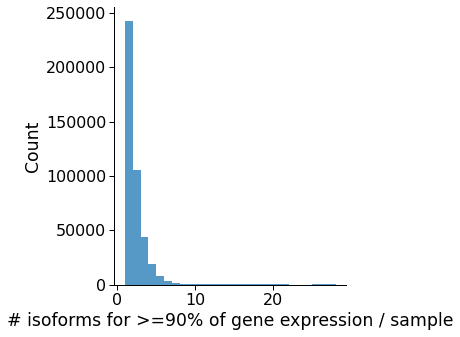

In [120]:
sns.set_context('paper', font_scale=1.8)
ax = sns.displot(data=iso_df, x='n_isos',
                 kind='hist',
                 binwidth=1,
                 linewidth=0)

xlabel = '# isoforms for >=90% of gene expression / sample'
ylabel = 'Count'

_ = ax.set(xlabel=xlabel, ylabel=ylabel)
fname = '{}_isos_pi_90.png'.format(opref)
plt.savefig(fname, dpi=300, bbox_inches='tight')   

### Gene-level exon analysis

Read in graph from swan.p
Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC']
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 156027
# isos >= 1 tpm: 141390
Applying gene type and novelty subset
Number of isos reported: 92963
Found 31 total samples


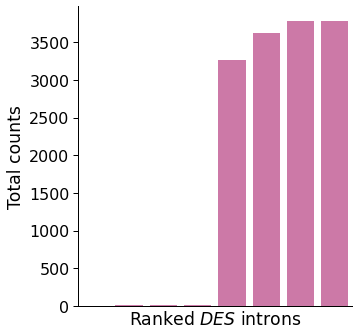

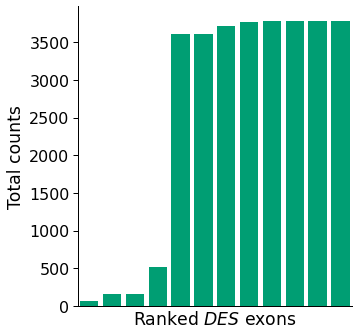

In [5]:
sg = swan.read('swan.p')
df = pd.read_csv('../talon/human_talon_abundance_filtered.tsv', sep='\t')
_ = plot_ranked_exon_counts(sg, df, 'DES', 
                        min_tpm=1, 
                        gene_subset='polya',
                        sample='all', 
                        groupby='sample', 
                        nov=['Known', 'NIC', 'NNC'], 
                        opref='figures/human')

Read in graph from swan.p
Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC']
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 156027
# isos >= 1 tpm: 141390
Applying gene type and novelty subset
Number of isos reported: 92963
Found 90 total libraries


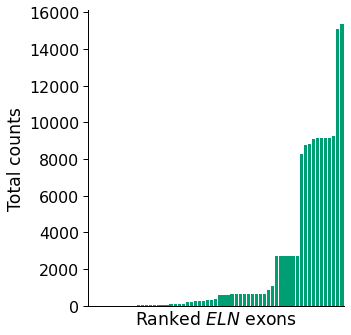

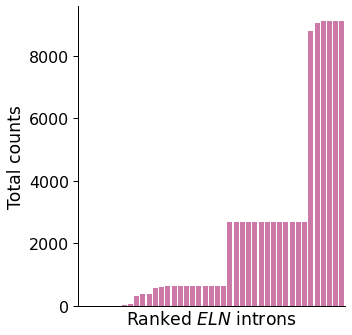

In [4]:
sg = swan.read('swan.p')
df = pd.read_csv('../talon/human_talon_abundance_filtered.tsv', sep='\t')
_ = plot_ranked_exon_counts(sg, df, 'ELN', 
                        min_tpm=1, 
                        gene_subset='polya',
                        sample='all', 
                        groupby='sample', 
                        nov=['Known', 'NIC', 'NNC'], 
                        opref='figures/human')

Read in graph from swan.p
Calculating iso TPM values
Subsetting for novelty categories ['Known', 'NIC', 'NNC']
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 156027
# isos >= 1 tpm: 141390
Applying gene type and novelty subset
Number of isos reported: 92963
Found 31 total samples
Found 139 isoforms for ELN


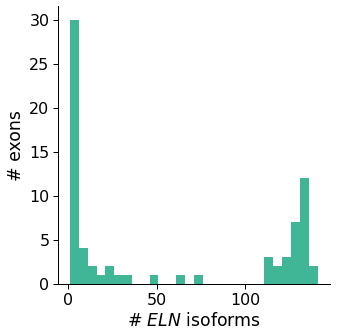

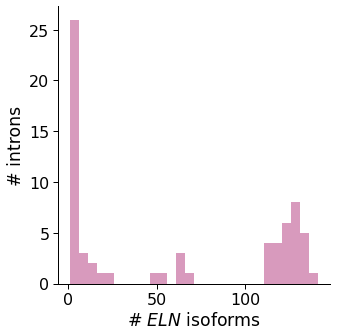

In [2]:
sg = swan.read('swan.p')
df = pd.read_csv('../talon/human_talon_abundance_filtered.tsv', sep='\t')
plot_exon_hist(sg, df, 'ELN',
               min_tpm=1,
               gene_subset='polya',
               sample='all', 
               groupby='sample', 
               nov=['Known', 'NIC', 'NNC'], 
               opref='figures/human')

In [3]:
sg.plot_graph('ELN', indicate_novel=True, prefix='figures/eln')

Saving summary graph for ENSG00000049540.16 as figures/eln_novel_ENSG00000049540.16_summary.png


In [4]:
sg.plot_graph('DES', indicate_novel=True, prefix='figures/des')

Saving summary graph for ENSG00000175084.11 as figures/des_novel_ENSG00000175084.11_summary.png


In [5]:
sg.plot_transcript_path('ENST00000373960.3', indicate_novel=True, prefix='figures/des')

Saving transcript path graph for ENST00000373960.3 as figures/des_novel_ENST00000373960.3_path.png


In [6]:
sg.plot_transcript_path('ENCODEHT002835059', indicate_novel=True, prefix='figures/des')

Saving transcript path graph for ENCODEHT002835059 as figures/des_novel_ENCODEHT002835059_path.png


## Reports

In [16]:
sg = swan.read('swan.p')

Read in graph from swan.p


In [17]:
def make_biosamp_reports(sg, gene):
    def make_reports(sg, gene, c):
        opref = 'figures/{}_{}'.format(gene.lower(), c)
        sg.gen_report(gene,
                  prefix=opref,
                  layer='pi',
                  cmap='magma',
                  novelty=True,
                  groupby='biosample',
                  transcript_name=True,
                  metadata_cols=['biosample'],
                  datasets={'classification': c},
                  browser=True)

        sg.gen_report(gene,
                      prefix=opref,
                      layer='tpm',
                      cmap='viridis',
                      novelty=True,
                      groupby='biosample',
                      transcript_name=True,
                      metadata_cols=['biosample'],
                      indicate_novel=True,
                      datasets={'classification': c})
        
    c = 'tissue'
    make_reports(sg, gene, c)
    c = 'cell_line'
    make_reports(sg, gene, c)    

In [129]:
make_biosamp_reports(sg, 'COL1A1')

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)



Plotting transcripts for ENSG00000108821.13
Saving transcript path graph for ENST00000225964.9 as figures/col1a1_tissue_browser_ENST00000225964.9_path.png
Saving transcript path graph for ENST00000510710.3 as figures/col1a1_tissue_browser_ENST00000510710.3_path.png
Saving transcript path graph for ENST00000463440.1 as figures/col1a1_tissue_browser_ENST00000463440.1_path.png
Generating report for ENSG00000108821.13


/Users/fairliereese/miniconda3/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)



Plotting transcripts for ENSG00000108821.13
Saving transcript path graph for ENST00000225964.9 as figures/col1a1_tissue_novel_ENST00000225964.9_path.png
Saving transcript path graph for ENST00000510710.3 as figures/col1a1_tissue_novel_ENST00000510710.3_path.png
Saving transcript path graph for ENST00000463440.1 as figures/col1a1_tissue_novel_ENST00000463440.1_path.png
Generating report for ENSG00000108821.13


/Users/fairliereese/miniconda3/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)



Plotting transcripts for ENSG00000108821.13
Saving transcript path graph for ENST00000225964.9 as figures/col1a1_cell_line_browser_ENST00000225964.9_path.png
Saving transcript path graph for ENST00000510710.3 as figures/col1a1_cell_line_browser_ENST00000510710.3_path.png
Saving transcript path graph for ENST00000476387.1 as figures/col1a1_cell_line_browser_ENST00000476387.1_path.png
Generating report for ENSG00000108821.13


/Users/fairliereese/miniconda3/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)



Plotting transcripts for ENSG00000108821.13
Saving transcript path graph for ENST00000225964.9 as figures/col1a1_cell_line_novel_ENST00000225964.9_path.png
Saving transcript path graph for ENST00000510710.3 as figures/col1a1_cell_line_novel_ENST00000510710.3_path.png
Saving transcript path graph for ENST00000476387.1 as figures/col1a1_cell_line_novel_ENST00000476387.1_path.png
Generating report for ENSG00000108821.13


In [127]:
make_biosamp_reports(sg, 'CAST')

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)



Plotting transcripts for ENSG00000153113.23
Saving transcript path graph for ENCODEHT000470977 as figures/cast_tissue_browser_ENCODEHT000470977_path.png
Saving transcript path graph for ENST00000309190.9 as figures/cast_tissue_browser_ENST00000309190.9_path.png
Saving transcript path graph for ENCODEHT000470926 as figures/cast_tissue_browser_ENCODEHT000470926_path.png
Saving transcript path graph for ENCODEHT000470707 as figures/cast_tissue_browser_ENCODEHT000470707_path.png
Saving transcript path graph for ENCODEHT000471452 as figures/cast_tissue_browser_ENCODEHT000471452_path.png
Saving transcript path graph for ENCODEHT001378016 as figures/cast_tissue_browser_ENCODEHT001378016_path.png
Saving transcript path graph for ENCODEHT000471422 as figures/cast_tissue_browser_ENCODEHT000471422_path.png
Saving transcript path graph for ENST00000395813.5 as figures/cast_tissue_browser_ENST00000395813.5_path.png
Saving transcript path graph for ENCODEHT000471440 as figures/cast_tissue_browser_E

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)



Plotting transcripts for ENSG00000153113.23
Saving transcript path graph for ENCODEHT000470977 as figures/cast_tissue_novel_ENCODEHT000470977_path.png
Saving transcript path graph for ENST00000309190.9 as figures/cast_tissue_novel_ENST00000309190.9_path.png
Saving transcript path graph for ENCODEHT000470926 as figures/cast_tissue_novel_ENCODEHT000470926_path.png
Saving transcript path graph for ENCODEHT000470707 as figures/cast_tissue_novel_ENCODEHT000470707_path.png
Saving transcript path graph for ENCODEHT000471452 as figures/cast_tissue_novel_ENCODEHT000471452_path.png
Saving transcript path graph for ENCODEHT001378016 as figures/cast_tissue_novel_ENCODEHT001378016_path.png
Saving transcript path graph for ENCODEHT000471422 as figures/cast_tissue_novel_ENCODEHT000471422_path.png
Saving transcript path graph for ENST00000395813.5 as figures/cast_tissue_novel_ENST00000395813.5_path.png
Saving transcript path graph for ENCODEHT000471440 as figures/cast_tissue_novel_ENCODEHT000471440_p

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)



Plotting transcripts for ENSG00000153113.23
Saving transcript path graph for ENST00000309190.9 as figures/cast_cell_line_browser_ENST00000309190.9_path.png
Saving transcript path graph for ENCODEHT000471422 as figures/cast_cell_line_browser_ENCODEHT000471422_path.png
Saving transcript path graph for ENCODEHT000471440 as figures/cast_cell_line_browser_ENCODEHT000471440_path.png
Saving transcript path graph for ENST00000508608.5 as figures/cast_cell_line_browser_ENST00000508608.5_path.png
Saving transcript path graph for ENST00000395812.6 as figures/cast_cell_line_browser_ENST00000395812.6_path.png
Saving transcript path graph for ENCODEHT000470977 as figures/cast_cell_line_browser_ENCODEHT000470977_path.png
Saving transcript path graph for ENCODEHT000471188 as figures/cast_cell_line_browser_ENCODEHT000471188_path.png
Saving transcript path graph for ENST00000395813.5 as figures/cast_cell_line_browser_ENST00000395813.5_path.png
Saving transcript path graph for ENCODEHT000470699 as figur

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)



Plotting transcripts for ENSG00000153113.23
Saving transcript path graph for ENST00000309190.9 as figures/cast_cell_line_novel_ENST00000309190.9_path.png
Saving transcript path graph for ENCODEHT000471422 as figures/cast_cell_line_novel_ENCODEHT000471422_path.png
Saving transcript path graph for ENCODEHT000471440 as figures/cast_cell_line_novel_ENCODEHT000471440_path.png
Saving transcript path graph for ENST00000508608.5 as figures/cast_cell_line_novel_ENST00000508608.5_path.png
Saving transcript path graph for ENST00000395812.6 as figures/cast_cell_line_novel_ENST00000395812.6_path.png
Saving transcript path graph for ENCODEHT000470977 as figures/cast_cell_line_novel_ENCODEHT000470977_path.png
Saving transcript path graph for ENCODEHT000471188 as figures/cast_cell_line_novel_ENCODEHT000471188_path.png
Saving transcript path graph for ENST00000395813.5 as figures/cast_cell_line_novel_ENST00000395813.5_path.png
Saving transcript path graph for ENCODEHT000470699 as figures/cast_cell_lin

In [128]:
make_biosamp_reports(sg, 'GGT1')

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)



Plotting transcripts for ENSG00000100031.18
Saving transcript path graph for ENCODEHT000414203 as figures/ggt1_tissue_browser_ENCODEHT000414203_path.png
Saving transcript path graph for ENCODEHT000414250 as figures/ggt1_tissue_browser_ENCODEHT000414250_path.png
Saving transcript path graph for ENST00000403838.5 as figures/ggt1_tissue_browser_ENST00000403838.5_path.png
Saving transcript path graph for ENST00000400382.5 as figures/ggt1_tissue_browser_ENST00000400382.5_path.png
Saving transcript path graph for ENCODEHT000414184 as figures/ggt1_tissue_browser_ENCODEHT000414184_path.png
Saving transcript path graph for ENCODEHT000414190 as figures/ggt1_tissue_browser_ENCODEHT000414190_path.png
Saving transcript path graph for ENCODEHT000414211 as figures/ggt1_tissue_browser_ENCODEHT000414211_path.png
Saving transcript path graph for ENCODEHT000414244 as figures/ggt1_tissue_browser_ENCODEHT000414244_path.png
Saving transcript path graph for ENCODEHT000414236 as figures/ggt1_tissue_browser_E

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)



Plotting transcripts for ENSG00000100031.18
Saving transcript path graph for ENCODEHT000414203 as figures/ggt1_tissue_novel_ENCODEHT000414203_path.png
Saving transcript path graph for ENCODEHT000414250 as figures/ggt1_tissue_novel_ENCODEHT000414250_path.png
Saving transcript path graph for ENST00000403838.5 as figures/ggt1_tissue_novel_ENST00000403838.5_path.png
Saving transcript path graph for ENST00000400382.5 as figures/ggt1_tissue_novel_ENST00000400382.5_path.png
Saving transcript path graph for ENCODEHT000414184 as figures/ggt1_tissue_novel_ENCODEHT000414184_path.png
Saving transcript path graph for ENCODEHT000414190 as figures/ggt1_tissue_novel_ENCODEHT000414190_path.png
Saving transcript path graph for ENCODEHT000414211 as figures/ggt1_tissue_novel_ENCODEHT000414211_path.png
Saving transcript path graph for ENCODEHT000414244 as figures/ggt1_tissue_novel_ENCODEHT000414244_path.png
Saving transcript path graph for ENCODEHT000414236 as figures/ggt1_tissue_novel_ENCODEHT000414236_p

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)



Plotting transcripts for ENSG00000100031.18
Saving transcript path graph for ENCODEHT000414250 as figures/ggt1_cell_line_browser_ENCODEHT000414250_path.png
Saving transcript path graph for ENCODEHT000414184 as figures/ggt1_cell_line_browser_ENCODEHT000414184_path.png
Saving transcript path graph for ENCODEHT000414203 as figures/ggt1_cell_line_browser_ENCODEHT000414203_path.png
Saving transcript path graph for ENCODEHT000414265 as figures/ggt1_cell_line_browser_ENCODEHT000414265_path.png
Saving transcript path graph for ENCODEHT000414207 as figures/ggt1_cell_line_browser_ENCODEHT000414207_path.png
Saving transcript path graph for ENST00000400382.5 as figures/ggt1_cell_line_browser_ENST00000400382.5_path.png
Saving transcript path graph for ENST00000403838.5 as figures/ggt1_cell_line_browser_ENST00000403838.5_path.png
Saving transcript path graph for ENCODEHT000414181 as figures/ggt1_cell_line_browser_ENCODEHT000414181_path.png
Saving transcript path graph for ENCODEHT000414194 as figur

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)



Plotting transcripts for ENSG00000100031.18
Saving transcript path graph for ENCODEHT000414250 as figures/ggt1_cell_line_novel_ENCODEHT000414250_path.png
Saving transcript path graph for ENCODEHT000414184 as figures/ggt1_cell_line_novel_ENCODEHT000414184_path.png
Saving transcript path graph for ENCODEHT000414203 as figures/ggt1_cell_line_novel_ENCODEHT000414203_path.png
Saving transcript path graph for ENCODEHT000414265 as figures/ggt1_cell_line_novel_ENCODEHT000414265_path.png
Saving transcript path graph for ENCODEHT000414207 as figures/ggt1_cell_line_novel_ENCODEHT000414207_path.png
Saving transcript path graph for ENST00000400382.5 as figures/ggt1_cell_line_novel_ENST00000400382.5_path.png
Saving transcript path graph for ENST00000403838.5 as figures/ggt1_cell_line_novel_ENST00000403838.5_path.png
Saving transcript path graph for ENCODEHT000414181 as figures/ggt1_cell_line_novel_ENCODEHT000414181_path.png
Saving transcript path graph for ENCODEHT000414194 as figures/ggt1_cell_lin

In [64]:
sg.gen_report('ELN',
              prefix='figures/eln_cell_line_pi',
              layer='pi',
              cmap='magma',
              novelty=True,
              groupby='biosample',
              transcript_name=True,
              metadata_cols=['biosample'],
              datasets={'classification': 'cell_line'},
              browser=True)

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)



Plotting transcripts for ENSG00000049540.16
Saving transcript path graph for ENCODEHT001481409 as figures/eln_cell_line_pi_browser_ENCODEHT001481409_path.png
Saving transcript path graph for ENST00000380576.9 as figures/eln_cell_line_pi_browser_ENST00000380576.9_path.png
Saving transcript path graph for ENST00000445912.5 as figures/eln_cell_line_pi_browser_ENST00000445912.5_path.png
Saving transcript path graph for ENST00000252034.11 as figures/eln_cell_line_pi_browser_ENST00000252034.11_path.png
Saving transcript path graph for ENST00000380575.8 as figures/eln_cell_line_pi_browser_ENST00000380575.8_path.png
Saving transcript path graph for ENCODEHT001481404 as figures/eln_cell_line_pi_browser_ENCODEHT001481404_path.png
Saving transcript path graph for ENCODEHT002323610 as figures/eln_cell_line_pi_browser_ENCODEHT002323610_path.png
Saving transcript path graph for ENCODEHT002323608 as figures/eln_cell_line_pi_browser_ENCODEHT002323608_path.png
Saving transcript path graph for ENCODEHT

In [7]:
sg.gen_report('ELN',
              prefix='figures/eln_cell_line',
              layer='tpm',
              cmap='viridis',
              novelty=True,
              groupby='biosample',
              transcript_name=True,
              metadata_cols=['biosample'],
              datasets={'classification': 'cell_line'},
              browser=True)

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)



Plotting transcripts for ENSG00000049540.16
Saving transcript path graph for ENCODEHT001481409 as figures/eln_cell_line_browser_ENCODEHT001481409_path.png
Saving transcript path graph for ENST00000380576.9 as figures/eln_cell_line_browser_ENST00000380576.9_path.png
Saving transcript path graph for ENST00000445912.5 as figures/eln_cell_line_browser_ENST00000445912.5_path.png
Saving transcript path graph for ENST00000252034.11 as figures/eln_cell_line_browser_ENST00000252034.11_path.png
Saving transcript path graph for ENST00000380575.8 as figures/eln_cell_line_browser_ENST00000380575.8_path.png
Saving transcript path graph for ENCODEHT001481404 as figures/eln_cell_line_browser_ENCODEHT001481404_path.png
Saving transcript path graph for ENCODEHT002323610 as figures/eln_cell_line_browser_ENCODEHT002323610_path.png
Saving transcript path graph for ENCODEHT002323608 as figures/eln_cell_line_browser_ENCODEHT002323608_path.png
Saving transcript path graph for ENCODEHT002323596 as figures/eln

In [18]:
make_biosamp_reports(sg, 'MYOG')

               ENST00000469289.1  ENST00000417324.1  ENST00000461467.1  \
biosample                                                                
adrenal gland           0.000000                0.0                0.0   
adipose                 0.000000                0.0                0.0   
colon                   0.000000                0.0                0.0   
colon                   1.423607                0.0                0.0   
ovary                   0.000000                0.0                0.0   

               ENST00000442987.3  ENST00000494149.2  ENST00000410691.1  \
biosample                                                                
adrenal gland                0.0           3.233415                0.0   
adipose                      0.0           0.000000                0.0   
colon                        0.0           0.000000                0.0   
colon                        0.0           0.000000                0.0   
ovary                        0.0     

In [3]:
make_biosamp_reports(sg, 'MEF2C')

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)



Plotting transcripts for ENSG00000081189.15
Saving transcript path graph for ENST00000510942.5 as figures/mef2c_tissue_browser_ENST00000510942.5_path.png
Saving transcript path graph for ENCODEHT000458385 as figures/mef2c_tissue_browser_ENCODEHT000458385_path.png
Saving transcript path graph for ENCODEHT000458453 as figures/mef2c_tissue_browser_ENCODEHT000458453_path.png
Saving transcript path graph for ENST00000508569.5 as figures/mef2c_tissue_browser_ENST00000508569.5_path.png
Saving transcript path graph for ENST00000511086.1 as figures/mef2c_tissue_browser_ENST00000511086.1_path.png
Saving transcript path graph for ENST00000637481.1 as figures/mef2c_tissue_browser_ENST00000637481.1_path.png
Saving transcript path graph for ENST00000629612.2 as figures/mef2c_tissue_browser_ENST00000629612.2_path.png
Saving transcript path graph for ENST00000627659.2 as figures/mef2c_tissue_browser_ENST00000627659.2_path.png
Saving transcript path graph for ENST00000424173.6 as figures/mef2c_tissue_

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)



Plotting transcripts for ENSG00000081189.15
Saving transcript path graph for ENST00000510942.5 as figures/mef2c_tissue_novel_ENST00000510942.5_path.png
Saving transcript path graph for ENCODEHT000458385 as figures/mef2c_tissue_novel_ENCODEHT000458385_path.png
Saving transcript path graph for ENCODEHT000458453 as figures/mef2c_tissue_novel_ENCODEHT000458453_path.png
Saving transcript path graph for ENST00000508569.5 as figures/mef2c_tissue_novel_ENST00000508569.5_path.png
Saving transcript path graph for ENST00000511086.1 as figures/mef2c_tissue_novel_ENST00000511086.1_path.png
Saving transcript path graph for ENST00000637481.1 as figures/mef2c_tissue_novel_ENST00000637481.1_path.png
Saving transcript path graph for ENST00000629612.2 as figures/mef2c_tissue_novel_ENST00000629612.2_path.png
Saving transcript path graph for ENST00000627659.2 as figures/mef2c_tissue_novel_ENST00000627659.2_path.png
Saving transcript path graph for ENST00000424173.6 as figures/mef2c_tissue_novel_ENST000004

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)



Plotting transcripts for ENSG00000081189.15
Saving transcript path graph for ENST00000510942.5 as figures/mef2c_cell_line_browser_ENST00000510942.5_path.png
Saving transcript path graph for ENCODEHT000458385 as figures/mef2c_cell_line_browser_ENCODEHT000458385_path.png
Saving transcript path graph for ENST00000508569.5 as figures/mef2c_cell_line_browser_ENST00000508569.5_path.png
Saving transcript path graph for ENCODEHT000458453 as figures/mef2c_cell_line_browser_ENCODEHT000458453_path.png
Saving transcript path graph for ENST00000511086.1 as figures/mef2c_cell_line_browser_ENST00000511086.1_path.png
Saving transcript path graph for ENCODEHT000458359 as figures/mef2c_cell_line_browser_ENCODEHT000458359_path.png
Saving transcript path graph for ENST00000637481.1 as figures/mef2c_cell_line_browser_ENST00000637481.1_path.png
Saving transcript path graph for ENCODEHT000458395 as figures/mef2c_cell_line_browser_ENCODEHT000458395_path.png
Saving transcript path graph for ENCODEHT000458420 

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)



Plotting transcripts for ENSG00000081189.15
Saving transcript path graph for ENST00000510942.5 as figures/mef2c_cell_line_novel_ENST00000510942.5_path.png
Saving transcript path graph for ENCODEHT000458385 as figures/mef2c_cell_line_novel_ENCODEHT000458385_path.png
Saving transcript path graph for ENST00000508569.5 as figures/mef2c_cell_line_novel_ENST00000508569.5_path.png
Saving transcript path graph for ENCODEHT000458453 as figures/mef2c_cell_line_novel_ENCODEHT000458453_path.png
Saving transcript path graph for ENST00000511086.1 as figures/mef2c_cell_line_novel_ENST00000511086.1_path.png
Saving transcript path graph for ENCODEHT000458359 as figures/mef2c_cell_line_novel_ENCODEHT000458359_path.png
Saving transcript path graph for ENST00000637481.1 as figures/mef2c_cell_line_novel_ENST00000637481.1_path.png
Saving transcript path graph for ENCODEHT000458395 as figures/mef2c_cell_line_novel_ENCODEHT000458395_path.png
Saving transcript path graph for ENCODEHT000458420 as figures/mef2c

In [4]:
make_biosamp_reports(sg, 'ELN')

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)



Plotting transcripts for ENSG00000049540.16
Saving transcript path graph for ENST00000445912.5 as figures/eln_tissue_browser_ENST00000445912.5_path.png
Saving transcript path graph for ENST00000252034.11 as figures/eln_tissue_browser_ENST00000252034.11_path.png
Saving transcript path graph for ENCODEHT001481409 as figures/eln_tissue_browser_ENCODEHT001481409_path.png
Saving transcript path graph for ENST00000380576.9 as figures/eln_tissue_browser_ENST00000380576.9_path.png
Saving transcript path graph for ENCODEHT002323610 as figures/eln_tissue_browser_ENCODEHT002323610_path.png
Saving transcript path graph for ENCODEHT002323608 as figures/eln_tissue_browser_ENCODEHT002323608_path.png
Saving transcript path graph for ENCODEHT002323596 as figures/eln_tissue_browser_ENCODEHT002323596_path.png
Saving transcript path graph for ENST00000458204.5 as figures/eln_tissue_browser_ENST00000458204.5_path.png
Saving transcript path graph for ENST00000380575.8 as figures/eln_tissue_browser_ENST0000

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)



Plotting transcripts for ENSG00000049540.16
Saving transcript path graph for ENST00000445912.5 as figures/eln_tissue_novel_ENST00000445912.5_path.png
Saving transcript path graph for ENST00000252034.11 as figures/eln_tissue_novel_ENST00000252034.11_path.png
Saving transcript path graph for ENCODEHT001481409 as figures/eln_tissue_novel_ENCODEHT001481409_path.png
Saving transcript path graph for ENST00000380576.9 as figures/eln_tissue_novel_ENST00000380576.9_path.png
Saving transcript path graph for ENCODEHT002323610 as figures/eln_tissue_novel_ENCODEHT002323610_path.png
Saving transcript path graph for ENCODEHT002323608 as figures/eln_tissue_novel_ENCODEHT002323608_path.png
Saving transcript path graph for ENCODEHT002323596 as figures/eln_tissue_novel_ENCODEHT002323596_path.png
Saving transcript path graph for ENST00000458204.5 as figures/eln_tissue_novel_ENST00000458204.5_path.png
Saving transcript path graph for ENST00000380575.8 as figures/eln_tissue_novel_ENST00000380575.8_path.png

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)



Plotting transcripts for ENSG00000049540.16
Saving transcript path graph for ENCODEHT001481409 as figures/eln_cell_line_browser_ENCODEHT001481409_path.png
Saving transcript path graph for ENST00000380576.9 as figures/eln_cell_line_browser_ENST00000380576.9_path.png
Saving transcript path graph for ENST00000445912.5 as figures/eln_cell_line_browser_ENST00000445912.5_path.png
Saving transcript path graph for ENST00000252034.11 as figures/eln_cell_line_browser_ENST00000252034.11_path.png
Saving transcript path graph for ENST00000380575.8 as figures/eln_cell_line_browser_ENST00000380575.8_path.png
Saving transcript path graph for ENCODEHT001481404 as figures/eln_cell_line_browser_ENCODEHT001481404_path.png
Saving transcript path graph for ENCODEHT002323610 as figures/eln_cell_line_browser_ENCODEHT002323610_path.png
Saving transcript path graph for ENCODEHT002323608 as figures/eln_cell_line_browser_ENCODEHT002323608_path.png
Saving transcript path graph for ENCODEHT002323596 as figures/eln

/Users/fairliereese/miniconda3/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)



Plotting transcripts for ENSG00000049540.16
Saving transcript path graph for ENCODEHT001481409 as figures/eln_cell_line_novel_ENCODEHT001481409_path.png
Saving transcript path graph for ENST00000380576.9 as figures/eln_cell_line_novel_ENST00000380576.9_path.png
Saving transcript path graph for ENST00000445912.5 as figures/eln_cell_line_novel_ENST00000445912.5_path.png
Saving transcript path graph for ENST00000252034.11 as figures/eln_cell_line_novel_ENST00000252034.11_path.png
Saving transcript path graph for ENST00000380575.8 as figures/eln_cell_line_novel_ENST00000380575.8_path.png
Saving transcript path graph for ENCODEHT001481404 as figures/eln_cell_line_novel_ENCODEHT001481404_path.png
Saving transcript path graph for ENCODEHT002323610 as figures/eln_cell_line_novel_ENCODEHT002323610_path.png
Saving transcript path graph for ENCODEHT002323608 as figures/eln_cell_line_novel_ENCODEHT002323608_path.png
Saving transcript path graph for ENCODEHT002323596 as figures/eln_cell_line_novel

In [ ]:
make_biosamp_reports(sg, 'DES')

In [25]:
make_biosamp_reports('MYH7')


Plotting transcripts for ENSG00000092054.12
Saving transcript path graph for ENST00000355349.3 as figures/myh7_tissue_browser_ENST00000355349.3_path.png
Saving transcript path graph for ENCODEHT002509576 as figures/myh7_tissue_browser_ENCODEHT002509576_path.png
Saving transcript path graph for ENCODEHT002511948 as figures/myh7_tissue_browser_ENCODEHT002511948_path.png
Saving transcript path graph for ENCODEHT002511093 as figures/myh7_tissue_browser_ENCODEHT002511093_path.png
Saving transcript path graph for ENCODEHT002509562 as figures/myh7_tissue_browser_ENCODEHT002509562_path.png
Saving transcript path graph for ENCODEHT002509573 as figures/myh7_tissue_browser_ENCODEHT002509573_path.png
Saving transcript path graph for ENCODEHT002510879 as figures/myh7_tissue_browser_ENCODEHT002510879_path.png
Saving transcript path graph for ENCODEHT002509778 as figures/myh7_tissue_browser_ENCODEHT002509778_path.png
Saving transcript path graph for ENCODEHT002511483 as figures/myh7_tissue_browser_E

In [142]:
sg.set_metadata_colors('classification', {'cell_line': 'blue', 'tissue': 'pink'})
sg.gen_report('MYH7',
              prefix='figures/myh7_cell_line',
              layer='tpm',
              cmap='viridis',
              novelty=True,
              groupby='biosample',
              transcript_name=True,
              metadata_cols=['classification', 'biosample'],
              browser=True)


Plotting transcripts for ENSG00000092054.12
Saving transcript path graph for ENST00000355349.3 as figures/myh7_cell_line_browser_ENST00000355349.3_path.png
Saving transcript path graph for ENCODEHT002509576 as figures/myh7_cell_line_browser_ENCODEHT002509576_path.png
Saving transcript path graph for ENCODEHT002511948 as figures/myh7_cell_line_browser_ENCODEHT002511948_path.png
Saving transcript path graph for ENCODEHT002511093 as figures/myh7_cell_line_browser_ENCODEHT002511093_path.png
Saving transcript path graph for ENCODEHT002509573 as figures/myh7_cell_line_browser_ENCODEHT002509573_path.png
Saving transcript path graph for ENCODEHT002509778 as figures/myh7_cell_line_browser_ENCODEHT002509778_path.png
Saving transcript path graph for ENCODEHT002511483 as figures/myh7_cell_line_browser_ENCODEHT002511483_path.png
Saving transcript path graph for ENCODEHT002510879 as figures/myh7_cell_line_browser_ENCODEHT002510879_path.png
Saving transcript path graph for ENCODEHT002509562 as figur

In [141]:
sg.adata.obs.head()

,dataset,total_counts,biosample,classification,sample
index,,,,,
gm12878_1_1,gm12878_1_1,597843.0,gm12878,cell_line,gm12878
gm12878_1_2,gm12878_1_2,519604.0,gm12878,cell_line,gm12878
gm12878_1_3,gm12878_1_3,453017.0,gm12878,cell_line,gm12878
gm12878_1_4,gm12878_1_4,566864.0,gm12878,cell_line,gm12878
gm12878_3_1,gm12878_3_1,881857.0,gm12878,cell_line,gm12878


# where are the TSSs for Elastin?

In [15]:
df = sg.get_tss_abundance(kind='tpm')
df = df.loc[df.gname == 'ELN']

In [24]:
df

,tss_id,gid,gname,vertex_id,tss_name,chrom,coord,gm12878_1_1,gm12878_1_2,gm12878_1_3,...,psoas_muscle_1_1,right_cardiac_atrium_1_1,right_cardiac_atrium_3_1,right_cardiac_atrium_4_1,right_cardiac_atrium_2_1,right_lobe_of_liver_1_1,right_lobe_of_liver_2_1,right_ventricle_myocardium_inferior_1_1,right_ventricle_myocardium_superior_1_1,upper_lobe_of_right_lung_1_1
6500,ENSG00000049540.16_1,ENSG00000049540.16,ELN,821937,ELN_1,chr7,74027789,0.0,0.0,0.0,...,11.608784,47.126377,48.933109,39.749577,40.375385,0.0,7.196885,20.005281,13.122725,90.904961
6501,ENSG00000049540.16_2,ENSG00000049540.16,ELN,821938,ELN_2,chr7,74028101,0.0,0.0,0.0,...,2.902196,19.938084,26.256790,15.899831,12.288161,0.0,4.797924,0.000000,8.201703,28.407799
6502,ENSG00000049540.16_3,ENSG00000049540.16,ELN,821939,ELN_3,chr7,74028106,0.0,0.0,0.0,...,0.967399,0.000000,1.790236,1.987479,3.510903,0.0,2.398962,2.000528,1.640341,7.954184
6503,ENSG00000049540.16_4,ENSG00000049540.16,ELN,821940,ELN_4,chr7,74028109,0.0,0.0,0.0,...,0.000000,0.000000,0.596745,1.987479,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
6504,ENSG00000049540.16_5,ENSG00000049540.16,ELN,821941,ELN_5,chr7,74028114,0.0,0.0,0.0,...,0.967399,0.000000,1.790236,0.000000,0.000000,0.0,0.000000,2.000528,0.000000,3.408936
6505,ENSG00000049540.16_6,ENSG00000049540.16,ELN,821942,ELN_6,chr7,74028124,0.0,0.0,0.0,...,0.000000,0.000000,1.790236,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
6506,ENSG00000049540.16_7,ENSG00000049540.16,ELN,821943,ELN_7,chr7,74028126,0.0,0.0,0.0,...,0.000000,0.000000,0.596745,1.987479,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
6507,ENSG00000049540.16_8,ENSG00000049540.16,ELN,821944,ELN_8,chr7,74028129,0.0,0.0,0.0,...,0.000000,0.000000,4.177217,1.987479,0.000000,0.0,0.000000,0.000000,2.460511,0.000000
6508,ENSG00000049540.16_9,ENSG00000049540.16,ELN,821945,ELN_9,chr7,74028141,0.0,0.0,0.0,...,0.000000,1.812553,0.596745,0.000000,1.755452,0.0,0.000000,0.000000,1.640341,2.272624
6509,ENSG00000049540.16_10,ENSG00000049540.16,ELN,821946,ELN_10,chr7,74028144,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000


In [19]:
df.coord.max()-df.coord.min()

25062

In [21]:
df.coord.max()

74052851

In [22]:
df.coord.min()

74027789

In [26]:
tids = ['ENCODEHT001481409', 'ELN-209']

sg.t_df.loc[sg.t_df.tname.isin(tids), ['tname', 'loc_path']]

,tname,loc_path
tid,,
ENCODEHT001481409,ENCODEHT001481409,"[821951, 821955, 821956, 821957, 821959, 82196..."
ENST00000380576.9,ELN-209,"[821952, 821955, 821956, 821957, 821959, 82196..."


In [27]:
beep = sg.t_df.loc[sg.t_df.gname == 'ELN']

In [33]:
beep['tss'] = beep.apply(lambda x: x.loc_path[0], axis=1)
beep = beep.merge(df[['vertex_id', 'coord']], how='left', left_on='tss', right_on='vertex_id')

In [36]:
beep.loc[beep.tss == 822009]

,tname,gid,gname,path,tid,loc_path,annotation,novelty,tss,vertex_id,coord
147,ELN-224,ENSG00000049540.16,ELN,"[360442, 360443, 360344, 360345, 360346, 36034...",ENST00000466878.5,"[822009, 822010, 822012, 822015, 822016, 82201...",True,Known,822009,822009,74052294


In [43]:
df.head()

,tss_id,gid,gname,vertex_id,tss_name,chrom,coord,gm12878_1_1,gm12878_1_2,gm12878_1_3,...,psoas_muscle_1_1,right_cardiac_atrium_1_1,right_cardiac_atrium_3_1,right_cardiac_atrium_4_1,right_cardiac_atrium_2_1,right_lobe_of_liver_1_1,right_lobe_of_liver_2_1,right_ventricle_myocardium_inferior_1_1,right_ventricle_myocardium_superior_1_1,upper_lobe_of_right_lung_1_1
6500,ENSG00000049540.16_1,ENSG00000049540.16,ELN,821937,ELN_1,chr7,74027789,0.0,0.0,0.0,...,11.608784,47.126377,48.933109,39.749577,40.375385,0.0,7.196885,20.005281,13.122725,90.904961
6501,ENSG00000049540.16_2,ENSG00000049540.16,ELN,821938,ELN_2,chr7,74028101,0.0,0.0,0.0,...,2.902196,19.938084,26.256790,15.899831,12.288161,0.0,4.797924,0.000000,8.201703,28.407799
6502,ENSG00000049540.16_3,ENSG00000049540.16,ELN,821939,ELN_3,chr7,74028106,0.0,0.0,0.0,...,0.967399,0.000000,1.790236,1.987479,3.510903,0.0,2.398962,2.000528,1.640341,7.954184
6503,ENSG00000049540.16_4,ENSG00000049540.16,ELN,821940,ELN_4,chr7,74028109,0.0,0.0,0.0,...,0.000000,0.000000,0.596745,1.987479,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
6504,ENSG00000049540.16_5,ENSG00000049540.16,ELN,821941,ELN_5,chr7,74028114,0.0,0.0,0.0,...,0.967399,0.000000,1.790236,0.000000,0.000000,0.0,0.000000,2.000528,0.000000,3.408936


In [48]:
# are the isoforms with the super far away tsss even expresed?
far_tss = [822009, 822011, 821967, 821992, 821989]
for tss in far_tss:
    print(df.loc[df.vertex_id == tss, sg.datasets].sum(axis=1))

6521    0.0
dtype: float32
6522    0.0
dtype: float32
6518    0.0
dtype: float32
6520    7.299387
dtype: float32
6519    0.0
dtype: float32


In [47]:
df.sort_values(by='coord')

,tss_id,gid,gname,vertex_id,tss_name,chrom,coord,gm12878_1_1,gm12878_1_2,gm12878_1_3,...,psoas_muscle_1_1,right_cardiac_atrium_1_1,right_cardiac_atrium_3_1,right_cardiac_atrium_4_1,right_cardiac_atrium_2_1,right_lobe_of_liver_1_1,right_lobe_of_liver_2_1,right_ventricle_myocardium_inferior_1_1,right_ventricle_myocardium_superior_1_1,upper_lobe_of_right_lung_1_1
6500,ENSG00000049540.16_1,ENSG00000049540.16,ELN,821937,ELN_1,chr7,74027789,0.0,0.0,0.0,...,11.608784,47.126377,48.933109,39.749577,40.375385,0.0,7.196885,20.005281,13.122725,90.904961
6501,ENSG00000049540.16_2,ENSG00000049540.16,ELN,821938,ELN_2,chr7,74028101,0.0,0.0,0.0,...,2.902196,19.938084,26.256790,15.899831,12.288161,0.0,4.797924,0.000000,8.201703,28.407799
6502,ENSG00000049540.16_3,ENSG00000049540.16,ELN,821939,ELN_3,chr7,74028106,0.0,0.0,0.0,...,0.967399,0.000000,1.790236,1.987479,3.510903,0.0,2.398962,2.000528,1.640341,7.954184
6503,ENSG00000049540.16_4,ENSG00000049540.16,ELN,821940,ELN_4,chr7,74028109,0.0,0.0,0.0,...,0.000000,0.000000,0.596745,1.987479,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
6504,ENSG00000049540.16_5,ENSG00000049540.16,ELN,821941,ELN_5,chr7,74028114,0.0,0.0,0.0,...,0.967399,0.000000,1.790236,0.000000,0.000000,0.0,0.000000,2.000528,0.000000,3.408936
6505,ENSG00000049540.16_6,ENSG00000049540.16,ELN,821942,ELN_6,chr7,74028124,0.0,0.0,0.0,...,0.000000,0.000000,1.790236,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
6506,ENSG00000049540.16_7,ENSG00000049540.16,ELN,821943,ELN_7,chr7,74028126,0.0,0.0,0.0,...,0.000000,0.000000,0.596745,1.987479,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
6507,ENSG00000049540.16_8,ENSG00000049540.16,ELN,821944,ELN_8,chr7,74028129,0.0,0.0,0.0,...,0.000000,0.000000,4.177217,1.987479,0.000000,0.0,0.000000,0.000000,2.460511,0.000000
6508,ENSG00000049540.16_9,ENSG00000049540.16,ELN,821945,ELN_9,chr7,74028141,0.0,0.0,0.0,...,0.000000,1.812553,0.596745,0.000000,1.755452,0.0,0.000000,0.000000,1.640341,2.272624
6509,ENSG00000049540.16_10,ENSG00000049540.16,ELN,821946,ELN_10,chr7,74028144,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000


In [49]:
74027789-74028188

-399